# Quant Factor Research & Backtesting

This notebook demonstrates a factor-based backtesting workflow for crypto assets (BTC-USD, ETH-USD).

**Strategies:**
1. Momentum (Trend Following)
2. Mean Reversion (Z-Score)
3. Moving Average Crossover

**Steps:**
1. Load Data
2. Calculate Factors
3. Backtest Strategies
4. Analyze Performance (Train/Test Split)

In [1]:
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import pandas as pd
import matplotlib.pyplot as plt
from data_loader import download_data
from factors import momentum_signal, mean_reversion_signal, ma_crossover_signal
from backtester import run_backtest
from metrics import calculate_metrics
from plotting import plot_equity_curves, plot_drawdowns

%matplotlib inline

## 1. Load Data

In [2]:
tickers = ['BTC-USD', 'ETH-USD']
start_date = '2017-01-01'
end_date = '2024-01-01'

prices = download_data(tickers, start_date, end_date)
prices.head()

/Users/bipinrai/git/Quant-trading-research-project/quant-factor-backtest/src/data_loader.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']


[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

Data download complete.


Ticker,BTC-USD,ETH-USD
Date,,
2017-11-09,7143.580078,320.884003
2017-11-10,6618.140137,299.252991
2017-11-11,6357.600098,314.681000
2017-11-12,5950.069824,307.907990
2017-11-13,6559.490234,316.716003


## 2. Define Strategies & Calculate Signals

In [3]:
# 1. Momentum Strategy (20-day lookback)
mom_signals = momentum_signal(prices, lookback_period=20)

# 2. Mean Reversion (20-day window, 1.5 std dev threshold)
mr_signals = mean_reversion_signal(prices, window=20, threshold=1.5)

# 3. MA Crossover (20/60)
ma_signals = ma_crossover_signal(prices, short_window=20, long_window=60)

## 3. Run Backtests

In [4]:
strategies = {
    'Momentum': mom_signals,
    'Mean Reversion': mr_signals,
    'MA Crossover': ma_signals
}

results = {}
equity_curves = pd.DataFrame(index=prices.index)
all_returns = pd.DataFrame(index=prices.index)

for name, signals in strategies.items():
    # We backtest on BTC-USD for simplicity in this aggregate view, or we can combine.
    # Let's run backtest for BTC-USD specifically to compare strategies on one asset.
    asset = 'BTC-USD'
    asset_prices = prices[[asset]]
    asset_signals = signals[[asset]]
    
    res = run_backtest(asset_prices, asset_signals)
    results[name] = res
    equity_curves[name] = res['equity_curve'][asset]
    all_returns[name] = res['returns'][asset]

# Add Buy & Hold Benchmark
bnh_returns = prices['BTC-USD'].pct_change().fillna(0)
equity_curves['Buy & Hold'] = 10000 * (1 + bnh_returns).cumprod()
all_returns['Buy & Hold'] = bnh_returns

## 4. Performance Analysis

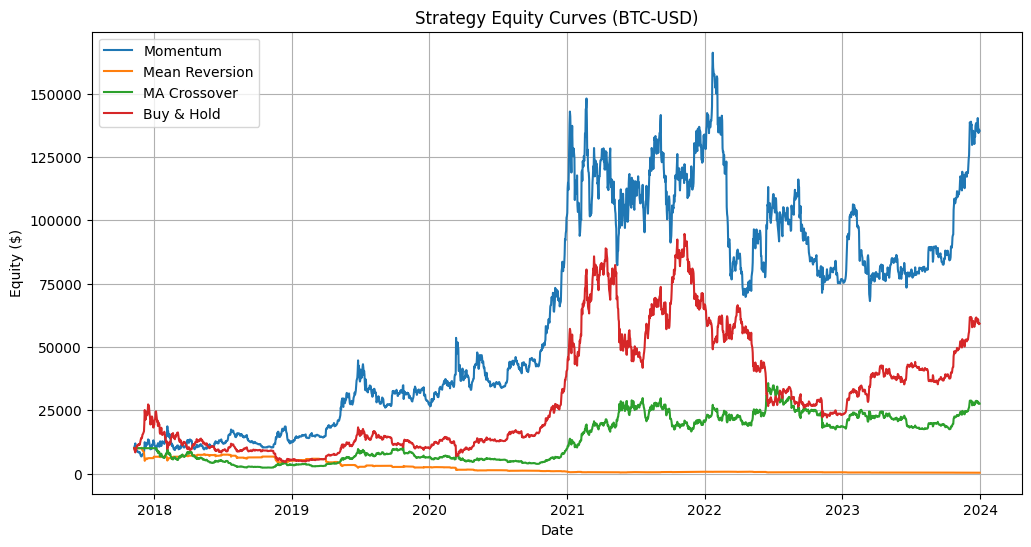

In [5]:
plot_equity_curves(equity_curves, title='Strategy Equity Curves (BTC-USD)')

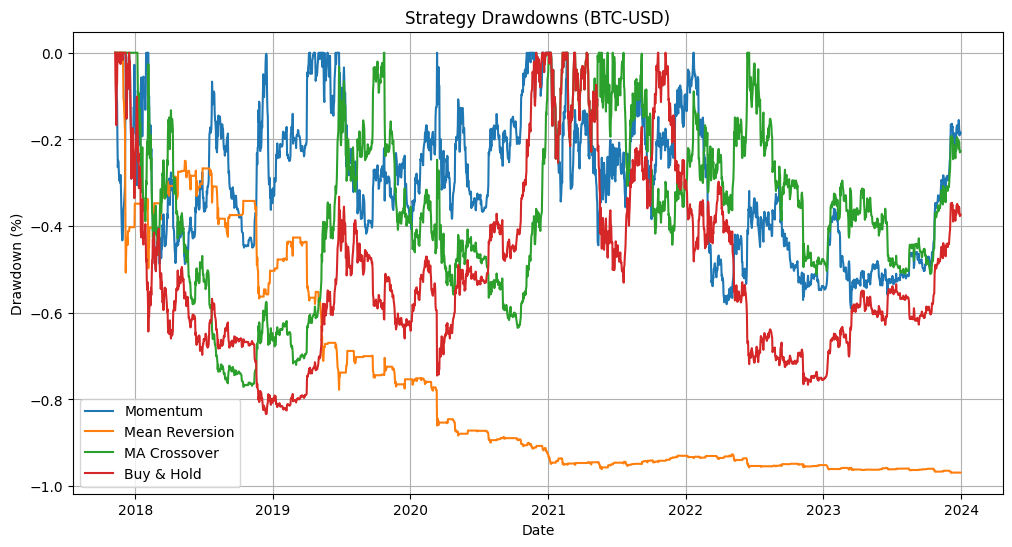

In [6]:
plot_drawdowns(all_returns, title='Strategy Drawdowns (BTC-USD)')

In [7]:
metrics = calculate_metrics(all_returns)
metrics

,CAGR,Volatility,Sharpe Ratio,Max Drawdown
Momentum,0.339803,0.597231,0.784501,-0.590203
Mean Reversion,-0.321691,0.384913,-0.802148,-0.969227
MA Crossover,0.120682,0.567181,0.482348,-0.770860
Buy & Hold,0.220964,0.597732,0.635889,-0.833990


## 5. Train / Test Split Analysis
Train: 2017-2021
Test: 2021-2024

In [8]:
split_date = '2021-01-01'

train_returns = all_returns.loc[:split_date]
test_returns = all_returns.loc[split_date:]

print("TRAIN PERIOD METRICS (2017 - 2021):")
display(calculate_metrics(train_returns))

print("\nTEST PERIOD METRICS (2021 - 2024):")
display(calculate_metrics(test_returns))

TRAIN PERIOD METRICS (2017 - 2021):


,CAGR,Volatility,Sharpe Ratio,Max Drawdown
Momentum,0.666614,0.650487,1.103822,-0.502811
Mean Reversion,-0.434942,0.430418,-1.090042,-0.927252
MA Crossover,-0.002454,0.596099,0.290388,-0.770860
Buy & Hold,0.363192,0.651512,0.806572,-0.833990



TEST PERIOD METRICS (2021 - 2024):


,CAGR,Volatility,Sharpe Ratio,Max Drawdown
Momentum,0.068180,0.535161,0.390595,-0.590203
Mean Reversion,-0.180386,0.330159,-0.432990,-0.580707
MA Crossover,0.269993,0.535076,0.713562,-0.511818
Buy & Hold,0.090538,0.535325,0.429638,-0.766346


## Conclusion
This notebook compared Momentum, Mean Reversion, and MA Crossover strategies against a Buy & Hold benchmark for BTC.

**Observations:**
- **Momentum** strategies often capture large trends in crypto but suffer during chop.
- **Mean Reversion** can be risky in strong trending markets if not filtered.
- **MA Crossover** is a lagged trend follower, often safer but slower to react.

Future work could involve parameter optimization, portfolio combination of strategies, and adding risk management (stop losses).